In [162]:
from ctypes import *
from dwfconstants import *
import math
import sys
import time
import matplotlib.pyplot as plt
import numpy

In [163]:
from ctypes import *
import sys

if sys.platform.startswith("win"):
    dwf = cdll.dwf
elif sys.platform.startswith("darwin"):
    dwf = cdll.LoadLibrary("libdwf.dylib")
else:
    dwf = cdll.LoadLibrary("libdwf.so")

In [170]:
hdwf = c_int()

version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("DWF Version: "+str(version.value))

print("Opening first device")
dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))

DWF Version: b'3.20.1'
Opening first device


1

FDwfDigitalOutInternalClockInfo - Retrives the internal clock frequency 

In [171]:
hzRate = 1e6 # frequency
cChannels = 8
cSamples = 16
cBytes = int(math.ceil(cSamples/8))
rgSamples = [0x0000,0x0001,0x0002,0x0003,0x0004,0x0005,0x0006,0x0007,0x0008,0x0009,0x000A,0x000B,0x000C,0x000D,0x000E,0x000F]
hzDO = c_double()
dwf.FDwfDigitalOutInternalClockInfo(hdwf, byref(hzDO))
print("clock frequency is", hzDO.value)

clock frequency is 100000000.0


FDwfDigitalOutEnableSet(HDWF hdwf, int idxChannel, int fEnable) - enables a digital output identified by channnel

FDwfDigitalOutTypeSet(HDWF hdwf, int idxChannel, DwfDigitalOutType v) - Set the type of output e.g. pulse, custom, random

FDwfDigitalOutDividerSet(HDWF hdwf, int idxChannel, unsigned int v) - sets the divider for a channel - e.g. sampe rate this uses the clock frequency divided by the requested clock output.

FDwfDigitalOutDataSet(
HDWF hdwf, int idxChannel, void *rgBits, unsigned int countOfBits - Sets the bits as below in the custom array which defines data and output enable the array is requried for each bit of the bus 

FDwfDigitalOutRunSet(HDWF hdwf, double secRun) - defines the run lentgh in seconds - here it is determined by the number of samples generared and the clock rate 

FDwfDigitalOutRepeatSet(HDWF hdwf, unsigned int cRepeat) - defines the number of repeat counters lol

)


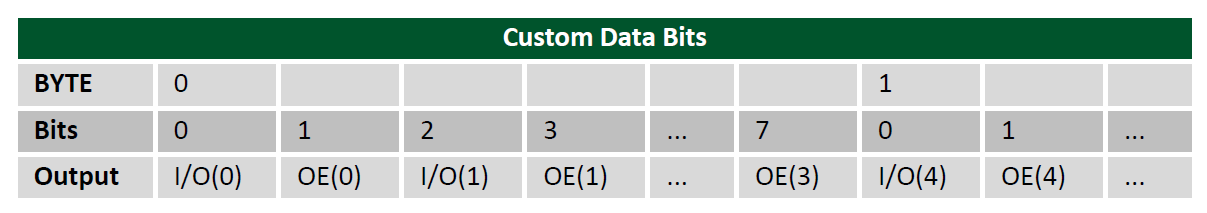

In [172]:
for channel in range(cChannels): # configure output channels
    rgBits = (cBytes*c_byte)() # custom bit array for each channel
    for sample in range(cSamples): # using the bits from samples array construct the bit array for the channel
        if(1&(rgSamples[int(sample)]>>channel)) : rgBits[int(sample/8)] |= 1<<(sample&7)
        else : rgBits[int(sample/8)] &= ~(1<<(sample&7))
    dwf.FDwfDigitalOutEnableSet(hdwf, c_int(channel), c_int(1))
    dwf.FDwfDigitalOutTypeSet(hdwf, c_int(channel), DwfDigitalOutTypeCustom)
    dwf.FDwfDigitalOutDividerSet(hdwf, c_int(channel), c_int(int(hzDO.value/hzRate))) # set sample rate
    dwf.FDwfDigitalOutDataSet(hdwf, c_int(channel), byref(rgBits), c_int(cSamples))

dwf.FDwfDigitalOutRunSet(hdwf, c_double(cSamples/hzRate)) # 160ns = 2*8 bits /100MHz = 16 bits * 10ns
dwf.FDwfDigitalOutRepeatSet(hdwf, c_int(1)) # once

1

Generate a clock 

In [173]:
dwf.FDwfDigitalOutEnableSet(hdwf, c_int(8), c_int(1))
dwf.FDwfDigitalOutTypeSet(hdwf, c_int(8), DwfDigitalOutTypePulse)
dwf.FDwfDigitalOutDividerSet(hdwf, c_int(8), c_int(int(hzDO.value/(2*hzRate))))
dwf.FDwfDigitalOutCounterSet(hdwf, c_int(8), c_int(1), c_int(1))

1

Run the instrument and send the data 

FDwfDigitalOutConfigure(HDWF hdwf, int fStart) - run the digital output

In [178]:
dwf.FDwfDigitalOutConfigure(hdwf, c_int(1))

1

In [169]:
dwf.FDwfDeviceCloseAll()


1